# **CIS 4190/5190 Fall 2025 - Homework 1**


# **Tips for Coding Homeworks**
Dear class, here are some tips to follow in coding HWs in this class, to minimize the chances of hitting hard-to-resolve bugs:

1.   **Do not set/alter random seeds.**
2.   Most bugs come down to minor errors in your code. The hardest and most important part of coding is debugging; debugging ML code is a key skillset you should acquire in this class.
3.   Good python coding avoids loops if at all possible: in particular, **for any vector and matrix operations, use `numpy` functions instead of loops**. This will often speed up your code by orders of magnitude. You may also want to take a look at the [python primer](https://www.seas.upenn.edu/~cis5190/fall2025/docs/basics_python_numpy.ipynb).
4.   Pay **extra attention to "copying" vs "moving" objects** i.e. take care during assignment operations. Otherwise, it may lead to incorrect results or Out Of Memory issues and Colab notebook restarts.
5.   If you are running into a `'__builtins__'` error, it's likely because you're using a function call of the form `numpy.ndarray.mean()`, like `a.mean()`. This is technically correct, but our autograding software PennGrader can't handle it. Please use the function **call `numpy.mean(a)` instead.**
6.   For this homework especially, pay **special attention to** the `compute_gradient` function and the `fit` function of the **Linear regression** section as these involve multiple key concepts.

Have fun coding up and training your first ML algorithms!


Please remember to **import libraries**, **set up PennGrader**, and **type in your PennID** to get points, especially when you do this HW module by module.

In [1]:
import random
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from numpy.linalg import *
np.random.seed(42)  # don't change this line!!

In [2]:
!pip install dill
from dill.source import getsource

NOTEBOOK = (os.getenv('IS_AUTOGRADER') is None)
if NOTEBOOK:
    print("[INFO, OK] Google Colab.")
else:
    print("[INFO, OK] Autograder.")

[INFO, OK] Google Colab.


# **PennGrader Setup**

First, you'll need to set up PennGrader, an autograder we are going to use throughout the semester. PennGrader will automatically grade your answer and provide you with instant feedback. Unless otherwise stated, you can resubmit up to a reasonable number of attempts (e.g. 100 attempts per day). **We will only record your latest score in our backend database**. To successfully get your grade, **please ensure your 8-Digit Penn-ID is entered correctly**. If not, the autograder won't know what result to check.

After finishing each homework assignment, you must submit your .ipynb notebook to Gradescope before the homework deadline. Gradescope will then retrieve and display your scores from our backend database.

In [3]:
%%capture
!pip3 install penngrader-client

In [4]:
%%writefile student_config.yaml
grader_api_url: 'https://23whrwph9h.execute-api.us-east-1.amazonaws.com/default/Grader23'
grader_api_key: 'flfkE736fA6Z8GxMDJe2q8Kfk8UDqjsG3GVqOFOa'

Writing student_config.yaml


In [5]:
from penngrader.grader import *

In [6]:
# Serialization code needed by the autograder
import inspect, sys
from IPython.core.magics.code import extract_symbols

def new_getfile(object, _old_getfile=inspect.getfile):
    if not inspect.isclass(object):
        return _old_getfile(object)

    # Lookup by parent module (as in current inspect)
    if hasattr(object, '__module__'):
        object_ = sys.modules.get(object.__module__)
        if hasattr(object_, '__file__'):
            return object_.__file__

    # If parent module is __main__, lookup by methods (NEW)
    for name, member in inspect.getmembers(object):
        if inspect.isfunction(member) and object.__qualname__ + '.' + member.__name__ == member.__qualname__:
            return inspect.getfile(member)
    else:
        raise TypeError('Source for {!r} not found'.format(object))
inspect.getfile = new_getfile

def grader_serialize(obj):
    cell_code = "".join(inspect.linecache.getlines(new_getfile(obj)))
    class_code = extract_symbols(cell_code, obj.__name__)[0][0]
    return class_code

In [7]:
#PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY. IF NOT, THE AUTOGRADER WON'T KNOW WHO
#TO ASSIGN POINTS TO IN OUR BACKEND
STUDENT_ID = 12345678       # YOUR PENN-ID GOES HERE AS AN INTEGER#

Run the following cell to initialize the autograder. This autograder will let you submit your code directly from this notebook and immediately get a score.

**NOTE:** Remember we store your submissions and check against other student's submissions... so, not that you would, but no cheating.

In [8]:
%%writefile notebook-config.yaml

grader_api_url: 'https://23whrwph9h.execute-api.us-east-1.amazonaws.com/default/Grader23'
grader_api_key: 'flfkE736fA6Z8GxMDJe2q8Kfk8UDqjsG3GVqOFOa'

Writing notebook-config.yaml


In [9]:
grader = PennGrader('notebook-config.yaml', 'cis5190_f25_HW1', STUDENT_ID, STUDENT_ID)

PennGrader initialized with Student ID: 12345678

Make sure this correct or we will not be able to store your grade


# **1. Linear Regression**

## **1.1. Linear Regression Implementation [40 pts, Autograded]**

In this section you will implement linear regression with both L1 and L2 regularization. Your class LinearRegression must implement the following API:

* `__init__(alpha, tol, max_iter, beta_init, penalty, lambd)`
* `compute_cost(beta, X, y)`
* `compute_gradient(beta, X, y)`
* `fit(X, y)`
* `has_converged(beta_old, beta_new)`
* `predict(X)`

Note that these methods have already been defined correctly for you in the LinearRegression class. **DO NOT** change the API.

### **1.1.1. Cost Function [9 pts]**

The `compute_cost` function should compute the cost for a given $\beta$ vector. The cost is a scalar value given by:

$
L({\beta}) = \frac{1}{N}\sum_{i =1}^N (f_{{\beta}}({x}_i) - y_i)^2
$

where

> $f_{{\beta}}({x}_i) = \beta^Tx_i$

Based on the regularization penalty, you may need to add below regularization penalty loss to MSE Loss computed previously.

L1 Regularization Loss:
>$
L_1({\beta}) = L({\beta}) + \lambda\sum_{j = 1}^D  |{\beta}_j|
$

L2 Regularization Loss:
>$
L_2({\beta}) = L({\beta}) + \lambda\sum_{j = 1}^D  {\beta}_j^2
$

$N$ is the number of training samples and $D$ is the number of features (excluding the intercept term). $\beta$ is a $D + 1$ dimensional vector, with the first element being the intercept term. **Note that we do not include the intercept in the regularization terms.**

---

### **1.1.2. Gradient of the Cost Function [9 pts]**

The `compute_gradient` function should compute the gradient of the cost function at a given $\beta$.

---

### **1.1.3. Convergence Check [2 pts]**

The `has_converged` function should return whether gradient descent algorithm has converged or not. Refer to the below section 1.1.4 for the convergence condition.

---

### **1.1.4. Training with Gradient Descent [8 pts]**

The `fit` method should train the model via gradient descent, relying on the cost and gradient functions. The trained weights/coefficients must be stored as `beta_`. The weights and the corresponding cost after every gradient descent iteration must be stored in `hist_beta_` and `hist_cost_` respectively.

* The gradient descent stops or converges when $\beta$ stops changing or changes negligibly between consecutive iterations; i.e., when
$\| {\beta}_\mathit{new} -  {\beta}_\mathit{old} \|_2 \leq \epsilon$,
for some small $\epsilon$ (e.g., $\epsilon$ = 1E-4). $\epsilon$ is stored as `tol` (short for tolerance).

* To ensure that the function terminates, you should set a maximum limit for the number of epochs, irrespective of whether $\beta$ converges or not. The limit is stored as `max_iter`.

* `alpha` is the learning rate of the gradient descent algorithm.

---

### **1.1.5. Training with Stochastic Gradient Descent (SGD) [8 pts]**

The `fit_sgd` method should train the model via stochastic gradient descent (SGD), relying on the cost and gradient functions.

The trained weights/coefficients must be stored as `beta_`. The weights and the corresponding cost after every SGD iteration must be stored in `hist_beta_` and `hist_cost_` respectively.

* Unlike regular (or batch) gradient descent, SGD takes a gradient step on a single training example on each iteration. In other words, rather than compute the gradient for all training examples, summing them, and taking a single gradient step, it iterates through training examples one by one, computing the gradient and performing a step for each. One pass over the entire training dataset is called an epoch; at the end of an epoch, the next epoch restarts from the first example in the training dataset.

* As with gradient descent, SGD stops or converges when $\beta$ stops changing or changes negligibly between consecutive iterations, i.e., when
$\| {\beta}_\mathit{new} -  {\beta}_\mathit{old} \|_2 \leq \epsilon$,
for some small $\epsilon$ (e.g., $\epsilon$ = 1E-4). $\epsilon$ is stored as `tol` (short for tolerance). Since each step is much shorter, SGD typically only checks for convergence at the **end of each epoch**.

* To ensure that the function terminates, you should set a maximum limit for the number of gradient descent iterations irrespective of whether $\beta$ converges or not. The limit is stored as `max_iter`.

* `alpha` is the learning rate of the SGD algorithm.

---

### **1.1.6. Predict [4 pts]**

The `predict` function should predict outputs given an input data matrix by applying the coefficient matrix.

---

Your implementation of the Linear Regression algorithm should closely follow the workflow described in the diagram below:

```plaintext
            ┌─────────────────────────────────────────────┐
            │                   init                      │
            │ (alpha, beta, max_iter, tol, penalty, lambd,│
            │            hist_cost_, hist_beta_)          │    
            └────────────────────┬────────────────────────┘
                                 │
                                 ▼
                    ┌────────────────────────┐
                    │ Choose training entry  │
                    │ point                  │
                    └────────────┬───────────┘
                                 │
                ┌────────────────┘───────────────┐
                ▼                                ▼
 ┌─────────────────────────────┐     ┌──────────────────────────────┐
 │ fit()                       │     │ fit_sgd()                    │
 │ (Batch Gradient Descent)    │     │ (Stochastic Gradient Descent)│
 └───────────────┬─────────────┘     └───────────────┬──────────────┘
                 │                                   │
                 ▼                                   ▼
 ┌───────────────────────────┐     ┌────────────────────────────────┐
 │ Loop per-dataset averaged:│     │ Loop per-sample/epoch:         │
 │ - compute_gradient()      │     │ - compute_gradient()           │
 │ - compute_cost()          │     │ - compute_cost()               │
 │ - has_converged()?        │     │ - has_converged()?             │
 └───────────────┬───────────┘     └───────────────┬────────────────┘
                 │                                 │
                 └───────────────┬─────────────────┘
                                 ▼
                      ┌─────────────────────┐
                      │ predict (Inference) │
                      └─────────────────────┘

```
---


In [10]:
from IPython.utils.dir2 import get_real_method
class LinearRegression:

    """
    Linear Regression

    Parameters
    ----------
    alpha: float, default=0.01
        Learning rate
    tol: float, default=0.0001
        Tolerance for stopping criteria
    max_iter: int, default=10000
        Maximum number of iterations of gradient descent
    beta_init: None (or) numpy.ndarray of shape (D + 1,)
        The initial weights; if None, all weights will be zero by default
    penalty: string, default = None
        The type of regularization if any. The other options are l1 and l2
    lambd: float, default = 1.0
        The parameter regularization constant (i.e. lambda)

    Attributes
    ----------
    beta_: numpy.ndarray of shape (D + 1,)
        The value of the coefficients after gradient descent has converged
        or the number of iterations hit the maximum limit
    hist_beta_: numpy.ndarray of shape (num_iter, D + 1) where num_iter is the number of gradient descent iterations
        Stores beta_ after every gradient descent iteration
    hist_cost_: numpy.ndarray of shape (num_iter,) where num_iter is the number of gradient descent iterations
        Stores cost after every gradient descent iteration
    """

    def __init__(self, alpha = 0.01, tol=1e-4, max_iter = 100, beta_init = None, penalty = None, lambd = 0):

        # store metadata
        self.alpha = alpha
        self.beta_init = beta_init
        self.max_iter = max_iter
        self.tol = tol
        self.penalty = penalty
        self.lambd = lambd

        self.beta_ = None
        self.hist_cost_ = None
        self.hist_beta_ = None

    def compute_cost(self, beta, X, y):

        """
        Compute the cost/objective function with penalty if any.

        Parameters
        ----------
        beta: numpy.ndarray of shape (D + 1,)
            The coefficients
        X: numpy.ndarray of shape (N, D + 1)
            The input features matrix
        y: numpy.ndarray of shape (N,)
            The target variable array

        Returns
        -------
        cost: float
            The cost as a scalar value
        """

        # STUDENT TODO STARTS: Complete the function (should account for three cases - no penalty, l1 penalty, and l2 penalty)
        N = X.shape[0]
        regularzied_cost = 0
        if self.penalty is None:
            regularzied_cost = 0
        elif self.penalty == "l1":
            regularzied_cost = self.lambd * np.sum(np.abs(beta[1:]))
        else :
             regularzied_cost = self.lambd * np.sum(beta[1:]**2)
        cost = np.mean((X.dot(beta) - y)**2)  + regularzied_cost
        return cost
        # STUDENT TODO ENDS

    def compute_gradient(self, beta, X, y):

        """
        Compute the gradient of the cost function with penalty if any.

        Parameters
        ----------
        beta: numpy.ndarray of shape (D + 1,)
            The coefficients
        X: numpy.ndarray of shape (N, D + 1)
            The input features matrix
        y: numpy.ndarray of shape (N,)
            The target variable array

        Returns
        -------
        gradient: numpy.ndarray of shape (D + 1,)
            The gradient values
        """

        # STUDENT TODO STARTS: Complete the function (should account for three cases - no penalty, l1 penalty, and l2 penalty)
        n = X.shape[0]
        gradient = 2 / n * ( -X.T @ y + X.T @ X @ beta)
        reg_grad = np.zeros_like(beta)
        # gradient = np.linalg.inv((X.T @ X)) @ X.T @ y
        if self.penalty is None:
            return gradient
        elif self.penalty == "l1":
            reg_grad[1:] = self.lambd * np.sign(beta[1:])
            return gradient + reg_grad
        else:
            reg_grad[1:] = self.lambd * 2 * beta[1:]
            return gradient + reg_grad
        # STUDENT TODO ENDS

    def has_converged(self, beta_old, beta_new):

        """
        Return whether gradient descent has converged.

        Parameters
        ----------
        beta_old: numpy.ndarray of shape (D + 1,)
            The weights prior to the update by gradient descent
        beta_new: numpy.ndarray of shape (D + 1,)
            The weights after the update by gradient descent

        Returns
        -------
        converged: bool
            Whether gradient descent converged or not
        """

        # STUDENT TODO START: Complete the function
        coverage = (beta_new - beta_old).dot(beta_new - beta_old)
        if np.sqrt(coverage) < self.tol:
            return True
        else:
            return False
        # STUDENT TODO END

    def fit(self, X, y):

        """
        Compute the coefficients using gradient descent and store them as beta_.

        Parameters
        ----------
        X: numpy.ndarray of shape (N, D)
            The input features matrix
        y: numpy.ndarray of shape (N,)
            The target variable array

        Returns
        -------
        Nothing
        """

        N, D = X.shape

        # Adding a column of ones at the beginning for the bias term
        ones_col = np.ones((N, 1))
        X = np.hstack((ones_col, X))

        # Initializing the weights
        if self.beta_init is None:
            beta_old = np.zeros((D + 1,))
        else:
            beta_old = self.beta_init

        # Initializing the historical weights matrix
        # Remember to append this matrix with the weights after every gradient descent iteration
        self.hist_beta_ = np.array([beta_old])
        # print(self.hi) - Removed this line as it causes AttributeError
        # Computing the cost for the initial weights
        cost = self.compute_cost(beta_old, X, y)

        # Initializing the historical cost array
        # Remember to append this array with the cost after every gradient descent iteration
        self.hist_cost_ = np.array([cost])
        self.beta_ = beta_old
        # STUDENT TODO START: Complete the function
        for i in range(self.max_iter):
            beta_old = self.beta_
            self.beta_ = beta_old - self.alpha * self.compute_gradient(beta_old, X, y)
            cost = self.compute_cost(self.beta_, X, y)
            if self.has_converged(beta_old, self.beta_):
               break
            self.hist_cost_ = np.append(self.hist_cost_, cost)
            self.hist_beta_ = np.vstack([self.hist_beta_, self.beta_.reshape(1,-1)])
        # STUDENT TODO END
    def fit_sgd(self, X, y, random_state=None):

        """
        Compute the coefficients using Stochastic Gradient Descent
        and store them as beta_.

        Parameters
        ----------
        X: numpy.ndarray of shape (N, D)
            The input features matrix
        y: numpy.ndarray of shape (N,)
            The target variable array

        Returns
        -------
        Nothing
        """

        N, D = X.shape

        # Adding a column of ones at the beginning for the bias term
        ones_col = np.ones((N, 1))
        X = np.hstack((ones_col, X))

        # Initializing the weights
        if self.beta_init is None:
            beta_old = np.zeros((D + 1,))
        else:
            beta_old = self.beta_init

        # Initializing the historical weights matrix
        # Remember to append this matrix with the weights after every gradient descent iteration
        self.hist_beta_ = np.array([beta_old])

        # Computing the cost for the initial weights
        cost = self.compute_cost(beta_old, X, y)

        # Initializing the historical cost array
        # Remember to append this array with the cost after every gradient descent iteration
        self.hist_cost_ = np.array([cost])

        # Init RNG, use it for shuffle
        if random_state is None:
            rng = np.random.default_rng()
        else:
            rng = np.random.default_rng(int(random_state))

        # Please use rng.permutation(N) for shuffle
        # STUDENT TODO START: Complete the function
        self.beta_ = beta_old
        for epoch in range(self.max_iter):
            indices = rng.permutation(N)
            x_shuffle = X[indices]
            y_shuffle = y[indices]
            for i in range(N):
                beta_old = self.beta_
                self.beta_ = beta_old - self.alpha * self.compute_gradient(beta_old, x_shuffle[i].reshape(1,-1), np.array([y_shuffle[i]]))
                cost = self.compute_cost(self.beta_, x_shuffle[i].reshape(1,-1), np.array([y_shuffle[i]]))
                self.hist_cost_ = np.append(self.hist_cost_, cost)
                self.hist_beta_ = np.vstack([self.hist_beta_, self.beta_.reshape(1,-1)])
            if self.has_converged(beta_old, self.beta_):
                    return
        # STUDENT TODO END

    def predict(self, X):

        """
        Predict the target variable values for the data points in X.

        Parameters
        ----------
        X: numpy.ndarray of shape (N, D)
            The input features matrix

        Returns
        -------
        y_hat: numpy.ndarray of shape (N,)
            The predicted target variables values for the data points in X
        """

        N = X.shape[0]
        X = np.hstack((np.ones((N, 1)), X))

        # STUDENT TODO START: Complete the function
        y_hat = X.dot(self.beta_)
        return y_hat
        # STUDENT TODO END

In [11]:
def test_lin_reg_compute_cost(StudentLinearRegression):

    test_case_beta = np.array([ 1.62434536, -0.61175641])
    test_case_X = np.array([[ 1.62434536, -0.61175641],
                            [-0.52817175, -1.07296862],
                            [ 0.86540763, -2.3015387 ],
                            [ 1.74481176, -0.7612069 ],
                            [ 0.3190391,  -0.24937038]])
    test_case_y = np.array([1, 1, 0, 0, 1])

    student_lr_reg = StudentLinearRegression()
    student_ans = student_lr_reg.compute_cost(test_case_beta, test_case_X, test_case_y)
    required_ans = 4.881828654157736

    assert np.abs(student_ans - required_ans) <= 1e-2

    student_lr_reg = StudentLinearRegression(penalty="l1", lambd=0.1)
    student_ans = student_lr_reg.compute_cost(test_case_beta, test_case_X, test_case_y)
    required_ans = 4.94300429515773

    assert np.abs(student_ans - required_ans) <= 1e-2

    student_lr_reg = StudentLinearRegression(penalty="l2", lambd=0.1)
    student_ans = student_lr_reg.compute_cost(test_case_beta, test_case_X, test_case_y)
    required_ans = 4.919253244675344
    assert np.abs(student_ans - required_ans) <= 1e-2

test_lin_reg_compute_cost(LinearRegression)

In [12]:
# PennGrader Grading Cell
grader.grade(test_case_id = 'test_lin_reg_compute_cost', answer = grader_serialize(LinearRegression))

Correct! You earned 9/9 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [13]:
def test_lin_reg_compute_gradient(StudentLinearRegression):

    test_case_beta = np.array([ 1.62434536, -0.61175641])
    test_case_X = np.array([[ 1.62434536, -0.61175641],
                            [-0.52817175, -1.07296862],
                            [ 0.86540763, -2.3015387 ],
                            [ 1.74481176, -0.7612069 ],
                            [ 0.3190391,  -0.24937038]])
    test_case_y = np.array([1, 1, 0, 0, 1])

    student_lr_reg = StudentLinearRegression()
    student_ans = student_lr_reg.compute_gradient(test_case_beta, test_case_X, test_case_y)
    required_ans = [ 4.79663712, -3.53908485]
    assert np.linalg.norm(student_ans - required_ans) <= 1e-2

    student_lr_reg = StudentLinearRegression(penalty="l1", lambd=0.1)
    student_ans = student_lr_reg.compute_gradient(test_case_beta, test_case_X, test_case_y)
    required_ans = [ 4.79663712, -3.63908485]

    assert np.linalg.norm(student_ans - required_ans) <= 1e-2

    student_lr_reg = StudentLinearRegression(penalty="l2", lambd=0.1)
    student_ans = student_lr_reg.compute_gradient(test_case_beta, test_case_X, test_case_y)
    required_ans = [ 4.79663712, -3.66143613]
    assert np.linalg.norm(student_ans - required_ans) <= 1e-2

test_lin_reg_compute_gradient(LinearRegression)

In [14]:
# PennGrader Grading Cell
grader.grade(test_case_id = 'test_lin_reg_compute_gradient', answer = grader_serialize(LinearRegression))

Correct! You earned 9/9 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [15]:
def test_lin_reg_has_converged(StudentLinearRegression):

    student_lr_reg = StudentLinearRegression()
    test_case_beta_old = np.array([ 1.62434536, -0.61175641])
    test_case_beta_new = np.array([1.624345, -0.611756])
    student_ans = student_lr_reg.has_converged(test_case_beta_old, test_case_beta_new)
    required_ans = True

    assert student_ans == required_ans

test_lin_reg_has_converged(LinearRegression)

In [16]:
# PennGrader Grading Cell
grader.grade(test_case_id = 'test_lin_reg_has_converged', answer = grader_serialize(LinearRegression))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [17]:
def test_lin_reg_fit(StudentLinearRegression):

    student_lr_reg = StudentLinearRegression(max_iter=5)
    test_case_X = np.array([[ 1.62434536, -0.61175641],
                            [-0.52817175, -1.07296862],
                            [ 0.86540763, -2.3015387 ],
                            [ 1.74481176, -0.7612069 ],
                            [ 0.3190391,  -0.24937038]])
    test_case_y = np.array([1, 1, 0, 0, 1])
    student_lr_reg.fit(test_case_X, test_case_y)
    student_ans = student_lr_reg.hist_beta_
    required_ans = np.array([[ 0.        ,  0.        ,  0.        ],
       [ 0.012     ,  0.00566085, -0.00773638],
       [ 0.02351422,  0.01085581, -0.01491529],
       [ 0.03457102,  0.01561393, -0.0215702 ],
       [ 0.04519706,  0.01996249, -0.02773259],
       [ 0.05541739,  0.02392713, -0.03343205]])
    assert np.linalg.norm(student_ans - required_ans) <= 1e-2

test_lin_reg_fit(LinearRegression)

In [18]:
# PennGrader Grading Cell
grader.grade(test_case_id = 'test_lin_reg_fit', answer = grader_serialize(LinearRegression))

Correct! You earned 8/8 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [19]:
from urllib import request
def test_lin_reg_fit_sgd(StudentLinearRegression):
    student_lr_reg = StudentLinearRegression(max_iter=5)
    test_case_X = np.array([[ 1.62434536, -0.61175641],
                            [-0.52817175, -1.07296862],
                            [ 0.86540763, -2.3015387 ],
                            [ 1.74481176, -0.7612069 ],
                            [ 0.3190391,  -0.24937038]])
    test_case_y = np.array([1, 1, 0, 0, 1])
    np.random.seed(42)
    student_lr_reg.fit_sgd(test_case_X, test_case_y,random_state=42)
    student_ans = student_lr_reg.hist_beta_
    required_ans = np.array([[ 0.,          0.,          0.        ],
                             [ 0.02,        0.00638078, -0.00498741],
                             [ 0.01925999,  0.00574037, -0.00328424],
                             [ 0.01862447,  0.00463151, -0.00280048],
                             [ 0.03824081, -0.00572928, -0.02384819],
                             [ 0.05737033,  0.02534367, -0.0355508 ],
                             [ 0.0547973,   0.02085421, -0.03359219],
                             [ 0.07261286,  0.04979283, -0.04449097],
                             [ 0.09073184,  0.0402229,  -0.06393207],
                             [ 0.08527817,  0.03550326, -0.05138025],
                             [ 0.10308982,  0.04118587, -0.05582195],
                             [ 0.09774564,  0.03656098, -0.04352212],
                             [ 0.11534038,  0.04217439, -0.04790973],
                             [ 0.13107727,  0.06773654, -0.05753687],
                             [ 0.14793655,  0.05883194, -0.07562635],
                             [ 0.14177346,  0.04807851, -0.07093497],
                             [ 0.13484065,  0.0420788,  -0.05497883],
                             [ 0.15160114,  0.04742606, -0.0591584 ],
                             [ 0.16630458,  0.07130952, -0.06815333],
                             [ 0.15945248,  0.05935389, -0.06293746],
                             [ 0.17553981,  0.05085702, -0.08019866],
                             [ 0.18939559,  0.07336358, -0.08867502],
                             [ 0.20447974,  0.06539656, -0.10485984],
                             [ 0.21944988,  0.07017262, -0.10859295],
                             [ 0.20884771,  0.06099742, -0.08419164],
                             [ 0.20126043,  0.04775905, -0.07841615]])
    assert np.linalg.norm(student_ans - required_ans) <= 1e-2
test_lin_reg_fit_sgd(LinearRegression)

In [20]:
# PennGrader Grading Cell
grader.grade(test_case_id = 'test_lin_reg_fit_sgd', answer = grader_serialize(LinearRegression))

Correct! You earned 8/8 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [21]:
def test_lin_reg_predict(StudentLinearRegression):

    student_lr_reg = StudentLinearRegression(max_iter=5)
    np.random.seed(1)
    test_case_X = np.random.randn(50, 2)
    test_case_y = np.random.randint(0, 2, 50)
    student_lr_reg.fit(test_case_X, test_case_y)
    student_ans = student_lr_reg.predict(test_case_X)
    required_ans = np.array([0.04739416, 0.02735934, 0.02140787, 0.04634383, 0.04320043,
       0.02836861, 0.03726417, 0.03808224, 0.03214353, 0.05166998,
       0.05102933, 0.05639199, 0.0416892 , 0.03175554, 0.04895695,
       0.03465034, 0.02912364, 0.03954521, 0.0396391 , 0.06440433,
       0.03189335, 0.06016748, 0.03661307, 0.07146111, 0.05261461,
       0.04180017, 0.03223834, 0.0500466 , 0.06128615, 0.05703506,
       0.05467262, 0.04388664, 0.04648138, 0.07052753, 0.04140456,
       0.02830984, 0.05608863, 0.0212115 , 0.05238969, 0.05514024,
       0.04020117, 0.05048966, 0.04696158, 0.04438422, 0.05897309,
       0.05443805, 0.03375689, 0.04794345, 0.04242038, 0.04869202])
    assert np.mean(np.abs(student_ans - required_ans)) <= 1e-2

test_lin_reg_predict(LinearRegression)

In [22]:
# PennGrader Grading Cell
grader.grade(test_case_id = 'test_lin_reg_predict', answer = grader_serialize(LinearRegression))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [23]:
def test_lin_reg_predict_sgd(StudentLinearRegression):

    student_lr_reg = StudentLinearRegression(max_iter=5)
    np.random.seed(1)
    test_case_X = np.random.randn(50, 2)
    test_case_y = np.random.randint(0, 2, 50)
    student_lr_reg.fit_sgd(test_case_X, test_case_y, random_state=1)
    student_ans = student_lr_reg.predict(test_case_X)
    required_ans = np.array([0.40692846, 0.21449028, 0.09548026, 0.38974227, 0.39264848, 0.1669377,
                             0.33574137, 0.3019747,  0.26525779, 0.51010281, 0.53662101, 0.54474898,
                             0.35549442, 0.2587561,  0.48460994, 0.31332467, 0.24204004, 0.37571796,
                             0.39049628, 0.62483088, 0.26262755, 0.64350889, 0.31600571, 0.76036112,
                             0.51989245, 0.3751962,  0.29598906, 0.49684306, 0.60965866, 0.57176677,
                             0.57299078, 0.39558417, 0.42973035, 0.71972543, 0.31274811, 0.25459013,
                             0.56340224, 0.10967673, 0.52996714, 0.54906182, 0.37050622, 0.49051677,
                             0.44474082, 0.43799543, 0.60169802, 0.51055005, 0.2921985,  0.4505304,
                             0.40277209, 0.49191095])
    assert np.mean(np.abs(student_ans - required_ans)) <= 1e-2

test_lin_reg_predict_sgd(LinearRegression)

In [24]:
# PennGrader Grading Cell
grader.grade(test_case_id = 'test_lin_reg_predict_sgd', answer = grader_serialize(LinearRegression))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## **1.2. Effect of polynomial degree on training and validation error [5190 Extra, 5pts, Manually Graded]**

Now, we consider a dataset that was generated using some higher degree polynomial function of the input variable. We do not know the degree of the underlying polynomial $p$, so let's try to estimate it.

Polynomial regression hypothesis for one input variable or feature $x$ can be written as:
> $y = w_0 + w_1x + w_2x^2 + ... + w_px^p $

If you observe carefully, this can still be solved as a linear regression, where, instead of just 2 weights, we have $p+1$ weights, and the new features are higher order terms of the original feature. Using this idea, we will investigate how changing the assumed polynomial degree $p$ in our model affects the training and validation error.

In [25]:
if not os.path.exists("cis5190_hw1_poly_reg.csv"):
    !wget https://raw.githubusercontent.com/upenn/cis-4190-5190-fall-25/main/hw1/cis5190_hw1_poly_reg.csv

poly_reg_df = pd.read_csv('cis5190_hw1_poly_reg.csv')

--2025-12-17 00:51:29--  https://raw.githubusercontent.com/upenn/cis-4190-5190-fall-25/main/hw1/cis5190_hw1_poly_reg.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50680 (49K) [text/plain]
Saving to: ‘cis5190_hw1_poly_reg.csv’

cis5190_hw1_poly_re 100%[===================>]  49.49K  --.-KB/s    in 0.04s   

2025-12-17 00:51:29 (1.25 MB/s) - ‘cis5190_hw1_poly_reg.csv’ saved [50680/50680]



Your task is to fit a Linear Regression model on this dataset after scaling base features into polynomial features of different degrees. Then, plot the variation of the train and test loss with respect to the assumed polynomial degree for the model. Perform the following steps for each degree $d$ in degrees:
1. Transform the base features `X_base` into polynomial features of degree `d` using `PolynomialFeatures` from `sklearn.preprocessing`. Set `include_bias` to be `False`
2. Split both `X_base` and `y` into train/test (70-30 train/test ratio and `random_state` as 42)
3. Scale `X_train` and `X_test` appropriately using `StandardScaler`
4. Use scikit-learn's `LinearRegression` (imported as `LinearRegressionSklearn` for you) to fit a linear model between the scaled version of `X_train` and `y_train`
5. Obtain predictions of the model on train and test data
6. Compute the mean squared error (MSE) and store it in `loss_train` and `loss_test`
7. Append `loss_train` to `loss_train_list` and `loss_test` to `loss_test_list`

In [26]:
import sklearn
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as LinearRegressionSklearn

def polynomial_regression(poly_reg_df, degrees):
    """
    Runs polynomial regression on dataset 'poly_reg_df' for all p in 'degrees'

    Parameters
    ----------
    poly_reg_df: numpy.ndarray of shape (N, D + 1)
        Input dataset with all input features and output label (last column)
    degrees: numpy.ndarray of shape (P,)
        List of polynomial degrees to run polynomial regression on

    Returns
    -------
    loss_train_list: list of length P (number of degrees to try)
        List of training losses for polynomial regression for all degrees
    loss_test_list: list of length P (number of degrees to try)
        List of testing losses for polynomial regression for all degrees
    """

    loss_train_list = []
    loss_test_list = []

    X_base = poly_reg_df.iloc[:, :-1].values
    y = poly_reg_df.iloc[:, -1].values

    for d in degrees:

        # STUDENT TODO START: Complete the function:
        pass
        # STUDENT TODO END

    return loss_train_list, loss_test_list

In [27]:
degrees = np.arange(1, 9)

loss_train_list, loss_test_list = polynomial_regression(poly_reg_df, degrees)

def plot_polynomial_regression(degrees, loss_train_list, loss_test_list):
  """
  Plot the train and test losses of polynomial regression for all d in 'degrees'

  Parameters
  ----------
  degrees: numpy.ndarray of shape (P,)
      List of polynomial degrees that polynomial regression was run on
  loss_train_list: list of length P (number of degrees to try)
      List of training losses for polynomial regression for all degrees
  loss_test_list: list of length P (number of degrees to try)
      List of testing losses for polynomial regression for all degrees

  Returns
  -------
  Nothing
  """

  # STUDENT TODO START:
  # Plot the polynomial degrees (x-axis) against loss_train_list (y-axis) and loss_test_list (y-axis) in a single plot, with different colors.
  # Make sure to include x and y axis labels, legend, as well as the title
  pass
  # STUDENT TODO END

plot_polynomial_regression(degrees, loss_train_list, loss_test_list)

## **1.3. Effect of learning rate on gradient descent [5190 Extra, 5pts, Manually Graded]**


Run the below cell to download the dataset.

In [28]:
if not os.path.exists("cis5190_hw1_admit.csv"):
    !wget https://raw.githubusercontent.com/upenn/cis-4190-5190-fall-25/main/hw1/cis5190_hw1_admit.csv

train_df = pd.read_csv("cis5190_hw1_admit.csv")

--2025-12-17 00:51:33--  https://raw.githubusercontent.com/upenn/cis-4190-5190-fall-25/main/hw1/cis5190_hw1_admit.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3609 (3.5K) [text/plain]
Saving to: ‘cis5190_hw1_admit.csv’

cis5190_hw1_admit.c 100%[===================>]   3.52K  --.-KB/s    in 0s      

2025-12-17 00:51:33 (27.6 MB/s) - ‘cis5190_hw1_admit.csv’ saved [3609/3609]



The dataset contains two features - the input is the scores in two exams and the target is whether the student was admitted into a college or not. Your task is to use this dataset and plot the **variation of the cost function with respect to the number of gradient descent iterations for different learning rates**. Perform the following steps:

1. Scale the features using StandardScaler
2. For each of the learning rates in `learning_rates`, fit a linear regression model to the scaled data by running a maximum of 100 iterations of gradient descent with L2 penalty and $\lambda$ as 0.001. Briefly comment on the effect of increasing the learning rate and what the best learning rate among the values would be based on the plot.
3. Show the variation of the cost (stored in `hist_cost_`) with respect to the number of iterations for all the learning rates in the same plot.


In [29]:
from sklearn.preprocessing import StandardScaler

learning_rates = [0.001, 0.01, 0.03, 0.1, 1.0]

In [30]:
def plot_lr_cost_var(train_df, learning_rates):
  """
  For each learning rate in learning_rates, plot the variations in cost for a
  Linear Regression model with that learning rate plus other settings specified above.

  Parameters
  ----------
  train_df: numpy.ndarray of shape (N, D + 1)
      Dataset with features and output labels
  learning_rates: list of length L (number of learning rates to try)
      List of learning rates to run Linear Regression with

  Returns
  -------
  Nothing
  """
  # STUDENT TODO STARTS:
  pass
  # STUDENT TODO ENDS

plot_lr_cost_var(train_df, learning_rates)

## **1.4. Synthetic dataset [ungraded]**

In this section we will first create some synthetic data on which we will run your linear regression implementation. We are creating 100 data points around the function $y = mx + b$, introducing Gaussian noise.

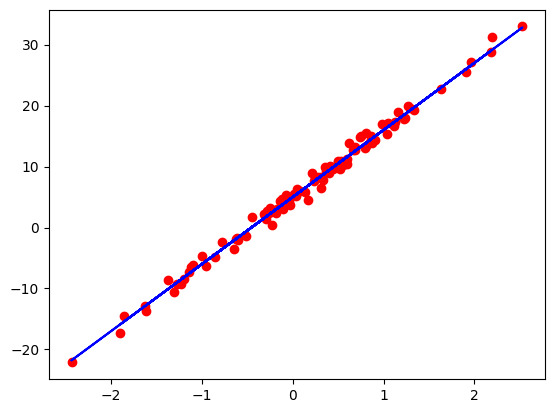

In [31]:
# Don't modify this cell
num_samples = 100

np.random.seed(1)
noise = np.random.randn(num_samples, 1)
X = np.random.randn(num_samples, 1)

y_ideal = 11*X + 5
y_real = (11*X + 5) + noise

plt.plot(X, y_real, 'ro')
plt.plot(X, y_ideal, 'b')

We see that this data is clearly regressable with a line, which, ideally, would be `11x + 5`

After training a linear regression model using gradient descent, you should see that training loss goes down with the number of iterations and you should obtain a $\beta$ that converges to a value very close to [b, m], which in this case, for `11x + 5`, would be $\beta$ = [5, 11]

Also, pay attention to the effect of the type of regularization on the $\beta$ obtained (after convergence) as well as the test MSE loss. Do they make sense, given what was discussed in class?

(70, 1)
(70,)

 beta: [ 5.00120552 10.99863221] 
 Norm of beta: 12.082299740311315 
 Testing MSELoss: 2.1379957881522386e-06
(2,)


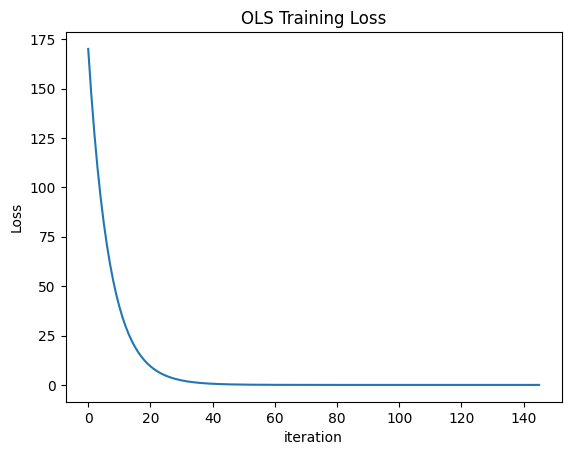

(70, 1)
(70,)

 beta: [ 5.00293128 10.98873294] 
 Norm of beta: 12.074004012300998 
 Testing MSELoss: 7.113216624523612e-05
(2,)


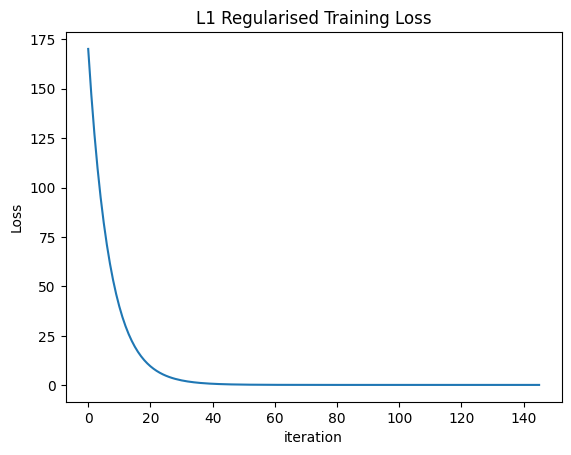

(70, 1)
(70,)

 beta: [ 5.03848665 10.78503368] 
 Norm of beta: 11.903919490265675 
 Testing MSELoss: 0.025010994877641184
(2,)


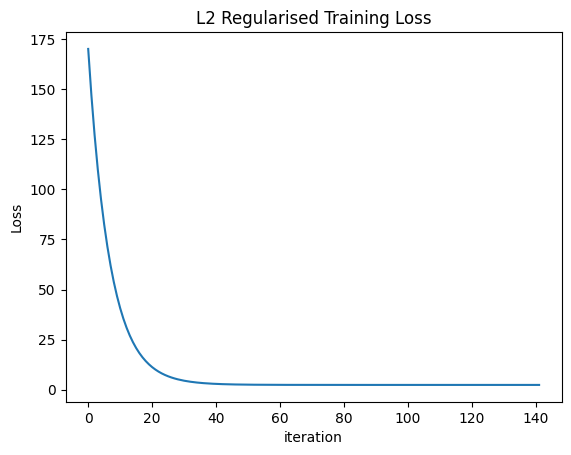

In [32]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def test_synthetic_data(X, y, n_iter = 2000, penalty=None, lambd=0):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=37)
  # Given that we want to get beta as the weights of the linear equation, we won't
  # standardize in this section

  alpha = 0.03  # Learning Rate
  print(y_train.shape)
  print(y_train[:, 0].shape)

  # Train the model
  lr_model = LinearRegression(alpha = alpha, tol=1e-4, max_iter = n_iter, penalty=penalty, lambd=lambd)
  lr_model.fit(X_train,y_train[:, 0])
  y_predict = lr_model.predict(X_test)
  loss = sklearn.metrics.mean_squared_error(y_predict, y_test)
  print()
  print(" beta: {} \n Norm of beta: {} \n Testing MSELoss: {}".format(lr_model.beta_, np.linalg.norm(lr_model.beta_, ord=2), loss))

  print(lr_model.beta_.shape)
  loss_history = lr_model.hist_cost_
  plt.plot(range(len(loss_history)), loss_history)
  plt.title("OLS Training Loss")
  plt.xlabel("iteration")
  plt.ylabel("Loss")
  if penalty == "l1":
    plt.title("L1 Regularised Training Loss")
  elif penalty == "l2":
    plt.title("L2 Regularised Training Loss")
  plt.show()

test_synthetic_data(X, y_ideal, 500)
test_synthetic_data(X, y_ideal, 500, "l1", 0.02)
test_synthetic_data(X, y_ideal, 500, "l2", 0.02)